In [2]:
from labml import lab, tracker, experiment, monit
from labml.configs import BaseConfigs, option
from labml_helpers.device import DeviceConfigs

In [15]:
"""
---
title: Denoising Diffusion Probabilistic Models (DDPM) training
summary: >
  Training code for
  Denoising Diffusion Probabilistic Model.
---

# [Denoising Diffusion Probabilistic Models (DDPM)](index.html) training

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)]
(https://colab.research.google.com/github/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/diffusion/ddpm/experiment.ipynb)

This trains a DDPM based model on CelebA HQ dataset. You can find the download instruction in this
[discussion on fast.ai](https://forums.fast.ai/t/download-celeba-hq-dataset/45873/3).
Save the images inside [`data/celebA` folder](#dataset_path).

The paper had used an exponential moving average of the model with a decay of $0.9999$. We have skipped this for
simplicity.

(obtained from: From: https://github.com/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/diffusion/ddpm/experiment.py)
"""

from typing import List

import torch
import torch.utils.data
import torchvision


from noise import DenoiseDiffusion
from unet import UNet



def main():
    # Settings for restoring/creating experiment

    LOAD_CHECKPOINT = True # True, False
    MY_UUID = 'AbeSaveTesting' 
    EXP = 'recurrent' # 'recurrent', 'residual'

    # Create experiment
    experiment.create(
        name='diffuse',
        writers={'screen', 'labml'},
        uuid=MY_UUID,
    )

    # Create configurations
    configs = Configs()
    print(f'Status: Device is using GPU: {torch.cuda.is_available()}')

    # Set the model
    configs.convolutional_block = EXP

    # Set configurations. You can override the defaults by passing the values in the dictionary.
    experiment.configs(configs, {
        'dataset': 'MNIST',  # 'CIFAR10', 'CelebA' 'MNIST'
        'image_channels': 1,  # 3, 3, 1
        'epochs': 5,  # 100, 100, 5
    })

    # Initialize
    configs.init()

    # Set models for saving and loading
    experiment.add_pytorch_models({'eps_model': configs.eps_model})

    if not LOAD_CHECKPOINT:
        # for exp in ['recurrent', 'residual']:
        for _ in ['recurrent']:
            """ configs.convolutional_block = exp

            # Set configurations. You can override the defaults by passing the values in the dictionary.
            experiment.configs(configs, {
                'dataset': 'MNIST',  # 'CIFAR10', 'CelebA' 'MNIST'
                'image_channels': 1,  # 3, 3, 1
                'epochs': 3,  # 100, 100, 5
            })

            # Initialize
            configs.init()

            # Set models for saving and loading 
            experiment.add_pytorch_models({'eps_model': configs.eps_model})"""

            # Start the experiment
            with experiment.start():
                configs.run()   

    elif LOAD_CHECKPOINT:
        checkpoint_uuid = MY_UUID # Note: set this to the checkpoint you want to load

        # Load the experiment from 
        experiment.load(run_uuid=checkpoint_uuid) # Note: there's also an optional checkpoint number param (checkpoint=[int])

        # Start the experiment (note: not using with experiment.start() when loading)
        with experiment.start():
            configs.run()   


class Configs(BaseConfigs):
    """
    Class for holding configuration parameters for training a DDPM model.

    Attributes:
        device (torch.device):           Device on which to run the model.
        eps_model (UNet):                U-Net model for the function `epsilon_theta`.
        diffusion (DenoiseDiffusion):    DDPM algorithm.
        image_channels (int):            Number of channels in the image (e.g. 3 for RGB).
        image_size (int):                Size of the image.
        n_channels (int):                Number of channels in the initial feature map.
        channel_multipliers (List[int]): Number of channels at each resolution.
        is_attention (List[bool]):       Indicates whether to use attention at each resolution.
        convolutional_block (str):       Type of the convolutional block used
        schedule_name (str):             Function of the noise schedule
        n_steps (int):                   Number of time steps.
        batch_size (int):                Batch size.
        n_samples (int):                 Number of samples to generate.
        learning_rate (float):           Learning rate.
        epochs (int):                    Number of training epochs.
        dataset (torch.utils.data.Dataset):         Dataset to be used for training.
        data_loader (torch.utils.data.DataLoader):  DataLoader for loading the data for training.
        optimizer (torch.optim.Adam):               Optimizer for the model.
    """

    # Device to train the model on.
    # [`DeviceConfigs`](https://docs.labml.ai/api/helpers.html#labml_helpers.device.DeviceConfigs)
    #  picks up an available CUDA device or defaults to CPU.
    device: torch.device = DeviceConfigs()
    # Retrieve model information
    show = True

    # U-Net model for $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$
    eps_model: UNet
    # [DDPM algorithm](index.html)
    diffusion: DenoiseDiffusion

    # Number of channels in the image. $3$ for RGB.
    image_channels: int = 3
    # Image size
    image_size: int = 32
    # Number of channels in the initial feature map
    n_channels: int = 64  # 64 (Default: Ho et al.; Limit is VRAM)
    # The list of channel numbers at each resolution.
    # The number of channels is `channel_multipliers[i] * n_channels`
    channel_multipliers: List[int] = [1, 2, 2, 4]
    # The list of booleans that indicate whether to use attention at each resolution
    is_attention: List[int] = [False, False, False, True]
    # Convolutional block type used in the UNet blocks. Possible options are 'residual' and 'recurrent'.
    convolutional_block = 'residual'

    # Defines the noise schedule. Possible options are 'linear' and 'cosine'.
    schedule_name: str = 'linear'
    # Number of time steps $T$ (with $T$ = 1_000 from Ho et al).
    n_steps: int = 1000  # 1000 (Default: Ho et al.)

    # Batch size
    batch_size: int = 64  # 64 (Default: Ho et al.; Limit is VRAM)
    # Number of samples to generate
    n_samples: int = 16
    # Learning rate
    learning_rate: float = 2e-5
    # Number of training epochs
    epochs: int = 1000

    # Dataset
    dataset: torch.utils.data.Dataset
    # Dataloader
    data_loader: torch.utils.data.DataLoader

    # Adam optimizer
    optimizer: torch.optim.Adam

    def init(self):
        """
        Initialize the model, dataset, and optimizer objects.
        """

        # Create $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$ model
        self.eps_model = UNet(
            image_channels=self.image_channels,
            n_channels=self.n_channels,
            ch_mults=self.channel_multipliers,
            is_attn=self.is_attention,
            conv_block=self.convolutional_block
        ).to(self.device)

        # Create [DDPM class](index.html)
        self.diffusion = DenoiseDiffusion(
            eps_model=self.eps_model,
            n_steps=self.n_steps,
            schedule_name=self.schedule_name,
            device=self.device,
        )

        # Show the number of params used by the model
        if self.show:
            pytorch_total_params = sum(p.numel() for p in self.eps_model.parameters())
            print(f'The total number of parameters are: {pytorch_total_params}')

        # Create dataloader
        self.data_loader = torch.utils.data.DataLoader(self.dataset, self.batch_size, shuffle=True, pin_memory=True)
        # Create optimizer
        self.optimizer = torch.optim.Adam(self.eps_model.parameters(), lr=self.learning_rate)

        # Image logging
        tracker.set_image("sample", True)

    def sample(self) -> None:
        """
        Generate samples from a trained Denoising Diffusion Probabilistic Model (DDPM).
        """

        with torch.no_grad():
            # Sample from the noise distribution at the final time step: x_T ~ p(x_T) = N(x_T; 0, I)
            x = torch.randn([self.n_samples, self.image_channels, self.image_size, self.image_size],
                            device=self.device)

            # Remove noise at each time step in reverse order (so remove noise for T steps)
            for t_ in monit.iterate('Sample', self.n_steps):
                # Get current time step
                t = self.n_steps - t_ - 1
                # Sample from the noise distribution at the current time step: x_{t-1} ~ p_theta(x_{t-1}|x_t)
                x = self.diffusion.p_sample(x, x.new_full((self.n_samples,), t, dtype=torch.long))

            # Log the final denoised samples
            tracker.save('sample', x)

    def train(self) -> None:
        """
        Train a Denoising Diffusion Probabilistic Model (DDPM) with the set dataloader.
        """

        # Iterate through the dataset
        for data in monit.iterate('Train', self.data_loader):
            # Increment global step
            tracker.add_global_step()
            # Move data to device
            data = data.to(self.device)

            # Make the gradients zero
            self.optimizer.zero_grad()
            # Calculate loss
            loss = self.diffusion.loss(data)
            # Compute gradients
            loss.backward()
            # Take an optimization step
            self.optimizer.step()
            # Track the loss
            tracker.save('loss', loss)

    def run(self):
        """
        ### Training loop
        """
        for _ in monit.loop(self.epochs):
            # Train the model
            self.train()
            # Sample some images
            self.sample()
            # New line in the console
            tracker.new_line()
            # Save the model
            experiment.save_checkpoint()


class MNISTDataset(torchvision.datasets.MNIST):
    """
    ### MNIST dataset
    """

    def __init__(self, image_size):
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(image_size),
            torchvision.transforms.ToTensor(),
        ])

        super().__init__(str(lab.get_data_path()), train=True, download=True, transform=transform)

    def __getitem__(self, item):
        return super().__getitem__(item)[0]


@option(Configs.dataset, 'MNIST')
def mnist_dataset(c: Configs):
    """
    Create MNIST dataset
    """
    return MNISTDataset(c.image_size)


class CIFAR10Dataset(torchvision.datasets.CIFAR10):
    """
    ### MNIST dataset
    """

    def __init__(self, image_size):
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(image_size),
            torchvision.transforms.ToTensor(),
        ])

        super().__init__(str(lab.get_data_path()), train=True, download=True, transform=transform)

    def __getitem__(self, item):
        return super().__getitem__(item)[0]


@option(Configs.dataset, 'CIFAR10')
def mnist_dataset(c: Configs):
    """
    Create CIFAR10 dataset
    """
    return CIFAR10Dataset(c.image_size)




HTML(value='<pre  style="overflow-x: scroll;"><span style="color: #C5C1B4"></span>\n<span style="color: #C5C1B…

Status: Device is using GPU: False
The total number of parameters are: 167775681


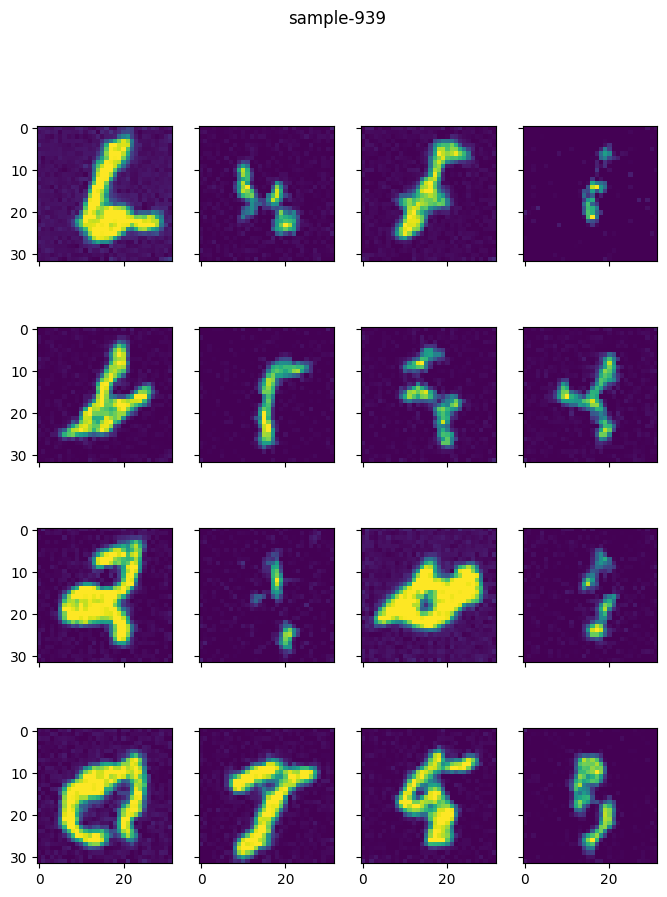

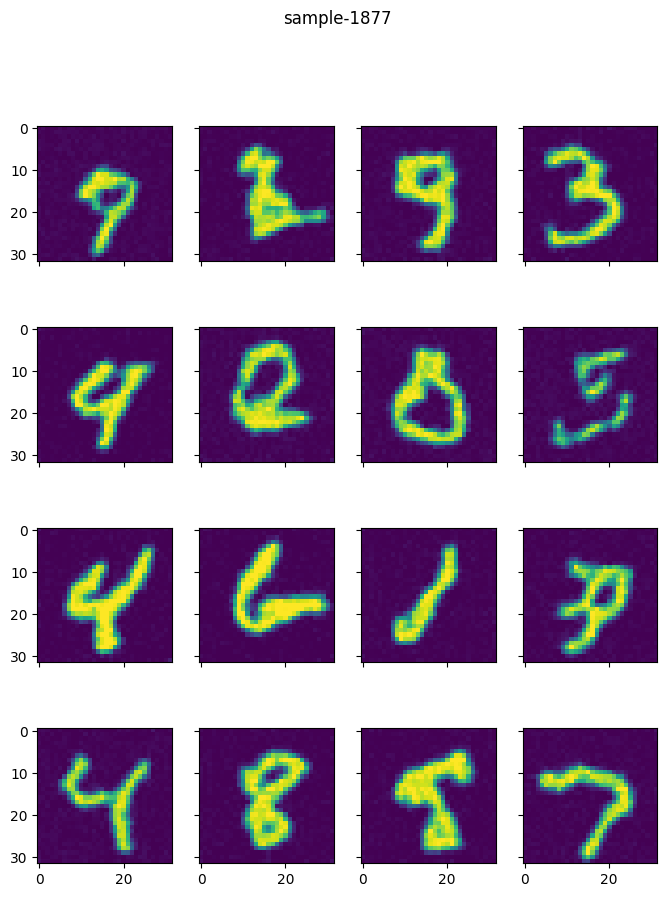

In [11]:
main()

In [16]:
# REMEMBER: set LOAD_CHECKPOINT to True if you want to load.
main()

HTML(value='<pre  style="overflow-x: scroll;"><span style="color: #C5C1B4"></span>\n<span style="color: #C5C1B…

Status: Device is using GPU: False
The total number of parameters are: 129079233


RuntimeError: Error(s) in loading state_dict for UNet:
	Missing key(s) in state_dict: "down.0.re.conv_input.weight", "down.0.re.norm_input.weight", "down.0.re.norm_input.bias", "down.0.re.skip.weight", "down.0.re.norm_skip.weight", "down.0.re.norm_skip.bias", "down.0.re.conv3.weight", "down.0.re.norm1_0.weight", "down.0.re.norm1_0.bias", "down.0.re.norm3_0.weight", "down.0.re.norm3_0.bias", "down.1.re.conv_input.weight", "down.1.re.norm_input.weight", "down.1.re.norm_input.bias", "down.1.re.skip.weight", "down.1.re.norm_skip.weight", "down.1.re.norm_skip.bias", "down.1.re.conv3.weight", "down.1.re.norm1_0.weight", "down.1.re.norm1_0.bias", "down.1.re.norm3_0.weight", "down.1.re.norm3_0.bias", "down.3.re.conv_input.weight", "down.3.re.norm_input.weight", "down.3.re.norm_input.bias", "down.3.re.skip.weight", "down.3.re.norm_skip.weight", "down.3.re.norm_skip.bias", "down.3.re.conv3.weight", "down.3.re.norm1_0.weight", "down.3.re.norm1_0.bias", "down.3.re.norm3_0.weight", "down.3.re.norm3_0.bias", "down.4.re.conv_input.weight", "down.4.re.norm_input.weight", "down.4.re.norm_input.bias", "down.4.re.skip.weight", "down.4.re.norm_skip.weight", "down.4.re.norm_skip.bias", "down.4.re.conv3.weight", "down.4.re.norm1_0.weight", "down.4.re.norm1_0.bias", "down.4.re.norm3_0.weight", "down.4.re.norm3_0.bias", "down.6.re.conv_input.weight", "down.6.re.norm_input.weight", "down.6.re.norm_input.bias", "down.6.re.skip.weight", "down.6.re.norm_skip.weight", "down.6.re.norm_skip.bias", "down.6.re.conv3.weight", "down.6.re.norm1_0.weight", "down.6.re.norm1_0.bias", "down.6.re.norm3_0.weight", "down.6.re.norm3_0.bias", "down.7.re.conv_input.weight", "down.7.re.norm_input.weight", "down.7.re.norm_input.bias", "down.7.re.skip.weight", "down.7.re.norm_skip.weight", "down.7.re.norm_skip.bias", "down.7.re.conv3.weight", "down.7.re.norm1_0.weight", "down.7.re.norm1_0.bias", "down.7.re.norm3_0.weight", "down.7.re.norm3_0.bias", "down.9.re.conv_input.weight", "down.9.re.norm_input.weight", "down.9.re.norm_input.bias", "down.9.re.skip.weight", "down.9.re.norm_skip.weight", "down.9.re.norm_skip.bias", "down.9.re.conv3.weight", "down.9.re.norm1_0.weight", "down.9.re.norm1_0.bias", "down.9.re.norm3_0.weight", "down.9.re.norm3_0.bias", "down.10.re.conv_input.weight", "down.10.re.norm_input.weight", "down.10.re.norm_input.bias", "down.10.re.skip.weight", "down.10.re.norm_skip.weight", "down.10.re.norm_skip.bias", "down.10.re.conv3.weight", "down.10.re.norm1_0.weight", "down.10.re.norm1_0.bias", "down.10.re.norm3_0.weight", "down.10.re.norm3_0.bias", "middle.re1.conv_input.weight", "middle.re1.norm_input.weight", "middle.re1.norm_input.bias", "middle.re1.skip.weight", "middle.re1.norm_skip.weight", "middle.re1.norm_skip.bias", "middle.re1.conv3.weight", "middle.re1.norm1_0.weight", "middle.re1.norm1_0.bias", "middle.re1.norm3_0.weight", "middle.re1.norm3_0.bias", "middle.re2.conv_input.weight", "middle.re2.norm_input.weight", "middle.re2.norm_input.bias", "middle.re2.skip.weight", "middle.re2.norm_skip.weight", "middle.re2.norm_skip.bias", "middle.re2.conv3.weight", "middle.re2.norm1_0.weight", "middle.re2.norm1_0.bias", "middle.re2.norm3_0.weight", "middle.re2.norm3_0.bias", "up.0.re.conv_input.weight", "up.0.re.norm_input.weight", "up.0.re.norm_input.bias", "up.0.re.skip.weight", "up.0.re.norm_skip.weight", "up.0.re.norm_skip.bias", "up.0.re.conv3.weight", "up.0.re.norm1_0.weight", "up.0.re.norm1_0.bias", "up.0.re.norm3_0.weight", "up.0.re.norm3_0.bias", "up.1.re.conv_input.weight", "up.1.re.norm_input.weight", "up.1.re.norm_input.bias", "up.1.re.skip.weight", "up.1.re.norm_skip.weight", "up.1.re.norm_skip.bias", "up.1.re.conv3.weight", "up.1.re.norm1_0.weight", "up.1.re.norm1_0.bias", "up.1.re.norm3_0.weight", "up.1.re.norm3_0.bias", "up.2.re.conv_input.weight", "up.2.re.norm_input.weight", "up.2.re.norm_input.bias", "up.2.re.skip.weight", "up.2.re.norm_skip.weight", "up.2.re.norm_skip.bias", "up.2.re.conv3.weight", "up.2.re.norm1_0.weight", "up.2.re.norm1_0.bias", "up.2.re.norm3_0.weight", "up.2.re.norm3_0.bias", "up.4.re.conv_input.weight", "up.4.re.norm_input.weight", "up.4.re.norm_input.bias", "up.4.re.skip.weight", "up.4.re.norm_skip.weight", "up.4.re.norm_skip.bias", "up.4.re.conv3.weight", "up.4.re.norm1_0.weight", "up.4.re.norm1_0.bias", "up.4.re.norm3_0.weight", "up.4.re.norm3_0.bias", "up.5.re.conv_input.weight", "up.5.re.norm_input.weight", "up.5.re.norm_input.bias", "up.5.re.skip.weight", "up.5.re.norm_skip.weight", "up.5.re.norm_skip.bias", "up.5.re.conv3.weight", "up.5.re.norm1_0.weight", "up.5.re.norm1_0.bias", "up.5.re.norm3_0.weight", "up.5.re.norm3_0.bias", "up.6.re.conv_input.weight", "up.6.re.norm_input.weight", "up.6.re.norm_input.bias", "up.6.re.skip.weight", "up.6.re.norm_skip.weight", "up.6.re.norm_skip.bias", "up.6.re.conv3.weight", "up.6.re.norm1_0.weight", "up.6.re.norm1_0.bias", "up.6.re.norm3_0.weight", "up.6.re.norm3_0.bias", "up.8.re.conv_input.weight", "up.8.re.norm_input.weight", "up.8.re.norm_input.bias", "up.8.re.skip.weight", "up.8.re.norm_skip.weight", "up.8.re.norm_skip.bias", "up.8.re.conv3.weight", "up.8.re.norm1_0.weight", "up.8.re.norm1_0.bias", "up.8.re.norm3_0.weight", "up.8.re.norm3_0.bias", "up.9.re.conv_input.weight", "up.9.re.norm_input.weight", "up.9.re.norm_input.bias", "up.9.re.skip.weight", "up.9.re.norm_skip.weight", "up.9.re.norm_skip.bias", "up.9.re.conv3.weight", "up.9.re.norm1_0.weight", "up.9.re.norm1_0.bias", "up.9.re.norm3_0.weight", "up.9.re.norm3_0.bias", "up.10.re.conv_input.weight", "up.10.re.norm_input.weight", "up.10.re.norm_input.bias", "up.10.re.skip.weight", "up.10.re.norm_skip.weight", "up.10.re.norm_skip.bias", "up.10.re.conv3.weight", "up.10.re.norm1_0.weight", "up.10.re.norm1_0.bias", "up.10.re.norm3_0.weight", "up.10.re.norm3_0.bias", "up.12.re.conv_input.weight", "up.12.re.norm_input.weight", "up.12.re.norm_input.bias", "up.12.re.skip.weight", "up.12.re.norm_skip.weight", "up.12.re.norm_skip.bias", "up.12.re.conv3.weight", "up.12.re.norm1_0.weight", "up.12.re.norm1_0.bias", "up.12.re.norm3_0.weight", "up.12.re.norm3_0.bias", "up.13.re.conv_input.weight", "up.13.re.norm_input.weight", "up.13.re.norm_input.bias", "up.13.re.skip.weight", "up.13.re.norm_skip.weight", "up.13.re.norm_skip.bias", "up.13.re.conv3.weight", "up.13.re.norm1_0.weight", "up.13.re.norm1_0.bias", "up.13.re.norm3_0.weight", "up.13.re.norm3_0.bias", "up.14.re.conv_input.weight", "up.14.re.norm_input.weight", "up.14.re.norm_input.bias", "up.14.re.skip.weight", "up.14.re.norm_skip.weight", "up.14.re.norm_skip.bias", "up.14.re.conv3.weight", "up.14.re.norm1_0.weight", "up.14.re.norm1_0.bias", "up.14.re.norm3_0.weight", "up.14.re.norm3_0.bias". 
	Unexpected key(s) in state_dict: "down.0.re.norm1.weight", "down.0.re.norm1.bias", "down.0.re.norm2.weight", "down.0.re.norm2.bias", "down.0.re.conv2.weight", "down.0.re.conv2.bias", "down.0.re.conv1.bias", "down.1.re.norm1.weight", "down.1.re.norm1.bias", "down.1.re.norm2.weight", "down.1.re.norm2.bias", "down.1.re.conv2.weight", "down.1.re.conv2.bias", "down.1.re.conv1.bias", "down.3.re.norm1.weight", "down.3.re.norm1.bias", "down.3.re.norm2.weight", "down.3.re.norm2.bias", "down.3.re.conv2.weight", "down.3.re.conv2.bias", "down.3.re.conv1.bias", "down.4.re.norm1.weight", "down.4.re.norm1.bias", "down.4.re.norm2.weight", "down.4.re.norm2.bias", "down.4.re.conv2.weight", "down.4.re.conv2.bias", "down.4.re.conv1.bias", "down.6.re.norm1.weight", "down.6.re.norm1.bias", "down.6.re.norm2.weight", "down.6.re.norm2.bias", "down.6.re.conv2.weight", "down.6.re.conv2.bias", "down.6.re.conv1.bias", "down.7.re.norm1.weight", "down.7.re.norm1.bias", "down.7.re.norm2.weight", "down.7.re.norm2.bias", "down.7.re.conv2.weight", "down.7.re.conv2.bias", "down.7.re.conv1.bias", "down.9.re.norm1.weight", "down.9.re.norm1.bias", "down.9.re.norm2.weight", "down.9.re.norm2.bias", "down.9.re.conv2.weight", "down.9.re.conv2.bias", "down.9.re.conv1.bias", "down.10.re.norm1.weight", "down.10.re.norm1.bias", "down.10.re.norm2.weight", "down.10.re.norm2.bias", "down.10.re.conv2.weight", "down.10.re.conv2.bias", "down.10.re.conv1.bias", "middle.re1.norm1.weight", "middle.re1.norm1.bias", "middle.re1.norm2.weight", "middle.re1.norm2.bias", "middle.re1.conv2.weight", "middle.re1.conv2.bias", "middle.re1.conv1.bias", "middle.re2.norm1.weight", "middle.re2.norm1.bias", "middle.re2.norm2.weight", "middle.re2.norm2.bias", "middle.re2.conv2.weight", "middle.re2.conv2.bias", "middle.re2.conv1.bias", "up.0.re.norm1.weight", "up.0.re.norm1.bias", "up.0.re.norm2.weight", "up.0.re.norm2.bias", "up.0.re.conv2.weight", "up.0.re.conv2.bias", "up.0.re.conv1.bias", "up.1.re.norm1.weight", "up.1.re.norm1.bias", "up.1.re.norm2.weight", "up.1.re.norm2.bias", "up.1.re.conv2.weight", "up.1.re.conv2.bias", "up.1.re.conv1.bias", "up.2.re.norm1.weight", "up.2.re.norm1.bias", "up.2.re.norm2.weight", "up.2.re.norm2.bias", "up.2.re.conv2.weight", "up.2.re.conv2.bias", "up.2.re.conv1.bias", "up.4.re.norm1.weight", "up.4.re.norm1.bias", "up.4.re.norm2.weight", "up.4.re.norm2.bias", "up.4.re.conv2.weight", "up.4.re.conv2.bias", "up.4.re.conv1.bias", "up.5.re.norm1.weight", "up.5.re.norm1.bias", "up.5.re.norm2.weight", "up.5.re.norm2.bias", "up.5.re.conv2.weight", "up.5.re.conv2.bias", "up.5.re.conv1.bias", "up.6.re.norm1.weight", "up.6.re.norm1.bias", "up.6.re.norm2.weight", "up.6.re.norm2.bias", "up.6.re.conv2.weight", "up.6.re.conv2.bias", "up.6.re.conv1.bias", "up.8.re.norm1.weight", "up.8.re.norm1.bias", "up.8.re.norm2.weight", "up.8.re.norm2.bias", "up.8.re.conv2.weight", "up.8.re.conv2.bias", "up.8.re.conv1.bias", "up.9.re.norm1.weight", "up.9.re.norm1.bias", "up.9.re.norm2.weight", "up.9.re.norm2.bias", "up.9.re.conv2.weight", "up.9.re.conv2.bias", "up.9.re.conv1.bias", "up.10.re.norm1.weight", "up.10.re.norm1.bias", "up.10.re.norm2.weight", "up.10.re.norm2.bias", "up.10.re.conv2.weight", "up.10.re.conv2.bias", "up.10.re.conv1.bias", "up.12.re.norm1.weight", "up.12.re.norm1.bias", "up.12.re.norm2.weight", "up.12.re.norm2.bias", "up.12.re.conv2.weight", "up.12.re.conv2.bias", "up.12.re.conv1.bias", "up.13.re.norm1.weight", "up.13.re.norm1.bias", "up.13.re.norm2.weight", "up.13.re.norm2.bias", "up.13.re.conv2.weight", "up.13.re.conv2.bias", "up.13.re.conv1.bias", "up.14.re.norm1.weight", "up.14.re.norm1.bias", "up.14.re.norm2.weight", "up.14.re.norm2.bias", "up.14.re.conv2.weight", "up.14.re.conv2.bias", "up.14.re.conv1.bias". 
	size mismatch for down.0.re.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for down.0.re.time_emb.weight: copying a param with shape torch.Size([64, 256]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for down.0.re.time_emb.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down.1.re.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for down.1.re.time_emb.weight: copying a param with shape torch.Size([64, 256]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for down.1.re.time_emb.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down.3.re.conv1.weight: copying a param with shape torch.Size([128, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 128, 1, 1]).
	size mismatch for down.3.re.time_emb.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for down.3.re.time_emb.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down.4.re.conv1.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 128, 1, 1]).
	size mismatch for down.4.re.time_emb.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for down.4.re.time_emb.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down.6.re.conv1.weight: copying a param with shape torch.Size([256, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for down.6.re.time_emb.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([512, 256]).
	size mismatch for down.6.re.time_emb.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down.7.re.conv1.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for down.7.re.time_emb.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([512, 256]).
	size mismatch for down.7.re.time_emb.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down.9.re.conv1.weight: copying a param with shape torch.Size([1024, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([2048, 1024, 1, 1]).
	size mismatch for down.9.re.time_emb.weight: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([2048, 256]).
	size mismatch for down.9.re.time_emb.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for down.10.re.conv1.weight: copying a param with shape torch.Size([1024, 1024, 3, 3]) from checkpoint, the shape in current model is torch.Size([2048, 1024, 1, 1]).
	size mismatch for down.10.re.time_emb.weight: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([2048, 256]).
	size mismatch for down.10.re.time_emb.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for middle.re1.conv1.weight: copying a param with shape torch.Size([1024, 1024, 3, 3]) from checkpoint, the shape in current model is torch.Size([2048, 1024, 1, 1]).
	size mismatch for middle.re1.time_emb.weight: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([2048, 256]).
	size mismatch for middle.re1.time_emb.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for middle.re2.conv1.weight: copying a param with shape torch.Size([1024, 1024, 3, 3]) from checkpoint, the shape in current model is torch.Size([2048, 1024, 1, 1]).
	size mismatch for middle.re2.time_emb.weight: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([2048, 256]).
	size mismatch for middle.re2.time_emb.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for up.0.re.conv1.weight: copying a param with shape torch.Size([1024, 2048, 3, 3]) from checkpoint, the shape in current model is torch.Size([2048, 1024, 1, 1]).
	size mismatch for up.0.re.time_emb.weight: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([2048, 256]).
	size mismatch for up.0.re.time_emb.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for up.1.re.conv1.weight: copying a param with shape torch.Size([1024, 2048, 3, 3]) from checkpoint, the shape in current model is torch.Size([2048, 1024, 1, 1]).
	size mismatch for up.1.re.time_emb.weight: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([2048, 256]).
	size mismatch for up.1.re.time_emb.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for up.2.re.conv1.weight: copying a param with shape torch.Size([256, 1280, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for up.2.re.time_emb.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([512, 256]).
	size mismatch for up.2.re.time_emb.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up.4.re.conv1.weight: copying a param with shape torch.Size([256, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for up.4.re.time_emb.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([512, 256]).
	size mismatch for up.4.re.time_emb.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up.5.re.conv1.weight: copying a param with shape torch.Size([256, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for up.5.re.time_emb.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([512, 256]).
	size mismatch for up.5.re.time_emb.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up.6.re.conv1.weight: copying a param with shape torch.Size([128, 384, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 128, 1, 1]).
	size mismatch for up.6.re.time_emb.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for up.6.re.time_emb.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up.8.re.conv1.weight: copying a param with shape torch.Size([128, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 128, 1, 1]).
	size mismatch for up.8.re.time_emb.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for up.8.re.time_emb.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up.9.re.conv1.weight: copying a param with shape torch.Size([128, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 128, 1, 1]).
	size mismatch for up.9.re.time_emb.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for up.9.re.time_emb.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up.10.re.conv1.weight: copying a param with shape torch.Size([64, 192, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for up.10.re.time_emb.weight: copying a param with shape torch.Size([64, 256]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for up.10.re.time_emb.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up.12.re.conv1.weight: copying a param with shape torch.Size([64, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for up.12.re.time_emb.weight: copying a param with shape torch.Size([64, 256]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for up.12.re.time_emb.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up.13.re.conv1.weight: copying a param with shape torch.Size([64, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for up.13.re.time_emb.weight: copying a param with shape torch.Size([64, 256]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for up.13.re.time_emb.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up.14.re.conv1.weight: copying a param with shape torch.Size([64, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for up.14.re.time_emb.weight: copying a param with shape torch.Size([64, 256]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for up.14.re.time_emb.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).